In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-dataset/train-images.idx3-ubyte
/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte
/kaggle/input/mnist-dataset/train-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte
/kaggle/input/mnist-dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte
/kaggle/input/mnist-dataset/train-images-idx3-ubyte/train-images-idx3-ubyte


# MNIST El Yazısı Rakam Veritabanı

**MNIST El Yazısı Rakam Veritabanı**, makine öğrenmesi ve derin öğrenme projeleri için yaygın olarak kullanılan bir veri kümesidir. Aşağıda projeyi özetleyen temel bilgileri bulabilirsiniz:

- **İçerik:** 0'dan 9'a kadar el yazısı ile yazılmış rakamlar.
- **Görüntü Boyutu:** Her rakam, 28x28 piksel boyutundadır.
- **Veri Miktarı:** Toplamda 70.000 örnek (60.000 eğitim, 10.000 test).
- **Kullanım Amacı:** Algoritmaların test edilmesi ve geliştirilmesi.
- **Uygulamalar:** Yapay sinir ağları, K-Nearest Neighbors (KNN), Support Vector Machines (SVM) gibi yöntemlerle sınıflandırma yapılabilir.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import struct
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
train_images_path = "/kaggle/input/mnist-dataset/train-images.idx3-ubyte"
train_labels_path = "/kaggle/input/mnist-dataset/train-labels.idx1-ubyte"
test_images_path = "/kaggle/input/mnist-dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte"
test_labels_path = "/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte"

def load_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [5]:
# Verileri yüklüyoruz
X_train = load_idx(train_images_path)
y_train = load_idx(train_labels_path)
X_test = load_idx(test_images_path)
y_test = load_idx(test_labels_path)

In [6]:
# verilerin boyutlarını kontrol edelim
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (60000, 28, 28)
X_test shape: (10000, 28, 28)
y_train shape: (60000,)
y_test shape: (10000,)


#### **Veri Seti Bilgi**  
| **Veri Türü**        | **Şekil**        | **Açıklama**                           |
|----------------------|------------------|----------------------------------------|
| `X_train`            | (60000, 28, 28)  | 60.000 adet eğitim görüntüsü (28x28 piksel) |
| `X_test`             | (10000, 28, 28)  | 10.000 adet test görüntüsü (28x28 piksel) |
| `y_train`            | (60000,)         | Eğitim verisine ait etiketler (0-9 arası) |
| `y_test`             | (10000,)         | Test verisine ait etiketler (0-9 arası) |

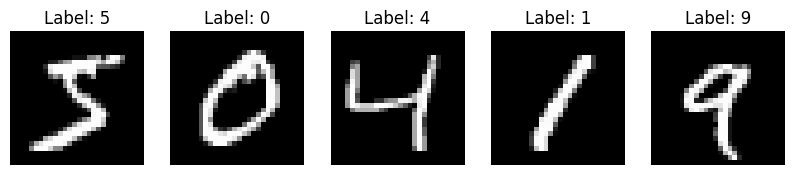

In [7]:
def plot_images(images, labels, num_images=5):
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()

# Örnek 5 görüntü ve etiket
plot_images(X_train, y_train, num_images=5)

In [8]:
# Görselleri 28x28 boyutlarından flatten işlemi yapıyoruz ve normalize edelim
X_train = X_train.reshape((X_train.shape[0], 28 * 28)).astype('float32') / 255
X_test = X_test.reshape((X_test.shape[0], 28 * 28)).astype('float32') / 255

In [9]:
# Flatten edilmiş boyutlarına tekrar bakalım.
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (60000, 784)
X_test shape: (10000, 784)


#### **1. Flatten (Düzleştirme)**  
- **Tanım:**  
  - Çok boyutlu bir diziyi (örneğin 28x28 piksel boyutunda) **tek boyutlu** bir diziye dönüştürme işlemidir.  
- **Amaç:**  
  - Yapay sinir ağları gibi modellerde, her görüntüyü **784** elemanlı (28 × 28 = 784) **tek boyutlu** bir diziye dönüştürerek işlemeyi kolaylaştırmak.

In [10]:
# Train ve validation olarak ayıralım.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### **1. One-Hot Encoding Nedir?**  
- **Tanım:**  
  One-hot encoding, her sınıfın bağımsız olarak temsil edilmesini sağlayan bir **dönüşüm tekniğidir**.  
  - **Amaç:**  
    - Etiketleri, **vektör formunda** ifade ederek, her sınıfa yalnızca bir pozisyonda `1` değeri atanmasını sağlar.  
    - Geri kalan tüm pozisyonlara `0` atanır.  

#### **Nasıl Çalışır?**  
- Her sınıf, yalnızca **tek bir pozisyondaki 1** değeri ile tanımlanır.  
- **Örnek:** MNIST veri setindeki sınıf etiketlerinin one-hot encoding dönüşümü:  
  - **Etiket 0:** `[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]`  
  - **Etiket 1:** `[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]`  
  - **Etiket 3:** `[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]`  

In [11]:
# Sınıfları one-hot encode edelim
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_val = tf.keras.utils.to_categorical(y_val, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [12]:
# Encode edilmiş değerleri görüntüleyelim.
y_train[:5]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

Yukarıdaki kodda, **`y_train`** veri setindeki ilk 5 etiketin **one-hot encoding** işlemi sonrası nasıl göründüğünü gösterir.  MNIST veri setindeki etiketler, **one-hot encoding** yöntemiyle dönüştürüldüğü için her satırda yalnızca **bir konumda 1** değeri, diğer tüm konumlarda **0** değeri bulunur.

### **1. Sequential Model Nedir?**  
Keras'ın **Sequential modeli**, katmanları sıralı bir şekilde ekleyerek basit bir **yapay sinir ağı** oluşturmayı sağlar.  
- Her katman, bir önceki katmanın çıktısını **girdi** olarak alır.  
- Bu model, **temel yapılı** ve **düz modeller** için idealdir.  

#### **Model Tanımlama**  

1. **Girdi Katmanı**  
   - **Input Katmanı:**  
     - Girdi boyutunu tanımlar.  
     - Bu durumda, **28x28** boyutundaki bir resim girişi (örneğin, MNIST veri setindeki el yazısı rakamlar) **784 boyutlu** bir vektöre dönüştürülmüştür.  

2. **Yoğun Katman**  
   - **Dense Katmanı:**  
     - **512 nörona** sahip ve **ReLU aktivasyon fonksiyonu** kullanır.  
     - Bu katman, girdi verisini işleyerek daha derin özellikler öğrenir.  

3. **Dropout Katmanı**  
   - **Dropout Katmanı:**  
     - **0.3 oranında dropout** uygular; yani her eğitim adımında **0.3 oranında** nöron rastgele kapatılır.  
     - Bu, **aşırı öğrenmeyi** (overfitting) azaltmak için kullanılır.  


In [13]:
# Modeli oluşturma
model = tf.keras.models.Sequential()

### Neden ReLU Kullandık?

ReLU aktivasyon fonksiyonu, derin öğrenme modelinde yaygın olarak tercih edilir çünkü:

- **Hızlı Öğrenme:** ReLU, negatif değerleri sıfırlayarak, pozitif değerleri olduğu gibi geçirdiği için, modelin daha hızlı öğrenmesini sağlar.
- **Aşırı Öğrenme Sorununu Azaltma:** ReLU, gradyanların sıfıra düşme olasılığını azaltır ve bu sayede daha iyi sonuçlar elde etmemizi sağlar.

In [14]:
# Input nesnesi olarak tanımlayın
model.add(tf.keras.layers.Input(shape=(28 * 28,)))

# Input katmanı
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))

In [15]:
 # Gizli katmanlar
model.add(tf.keras.layers.Dense(256, activation='relu')) #hidden layer1
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(128, activation='relu')) #hidden layer2
model.add(tf.keras.layers.Dropout(0.3))

In [16]:
# Output layer. Multi-class sınıflandırma için softmax kullanıyoruz.
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [17]:
# Modeli Derleyelim (Compile The Model)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # İzlenecek metrik (doğrulama kaybı)
    patience=3,          #  val_l oss iyileşmezse 3 epoch sonra durdur
    restore_best_weights=True,  # En iyi modelin ağırlıklarını geri yükle
    verbose=1            # Durum güncellemelerini yazdır
)

In [19]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # İzlenecek metrik (doğrulama kaybı)
    patience=3,          #  val_loss iyileşmezse 3 epoch sonra durdur
    restore_best_weights=True,  # En iyi modelin ağırlıklarını geri yükle
    verbose=1            # Durum güncellemelerini yazdır
)  

In [20]:
# Modeli eğitelim
results = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_val, y_val))

Epoch 1/10


I0000 00:00:1729357337.264986      66 service.cc:145] XLA service 0x7c887400a480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729357337.265041      66 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 83/375 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5731 - loss: 1.2703

I0000 00:00:1729357341.827849      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7780 - loss: 0.6853 - val_accuracy: 0.9582 - val_loss: 0.1371
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9514 - loss: 0.1680 - val_accuracy: 0.9696 - val_loss: 0.1024
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9661 - loss: 0.1182 - val_accuracy: 0.9717 - val_loss: 0.0909
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9718 - loss: 0.0968 - val_accuracy: 0.9758 - val_loss: 0.0831
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9754 - loss: 0.0798 - val_accuracy: 0.9744 - val_loss: 0.0866
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9784 - loss: 0.0693 - val_accuracy: 0.9788 - val_loss: 0.0718
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9819 - loss: 0.0578 - val_accuracy: 0.9792 - val_loss: 0.0746
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9834 - loss: 0.0558 - val_accuracy: 0.9795 - val_

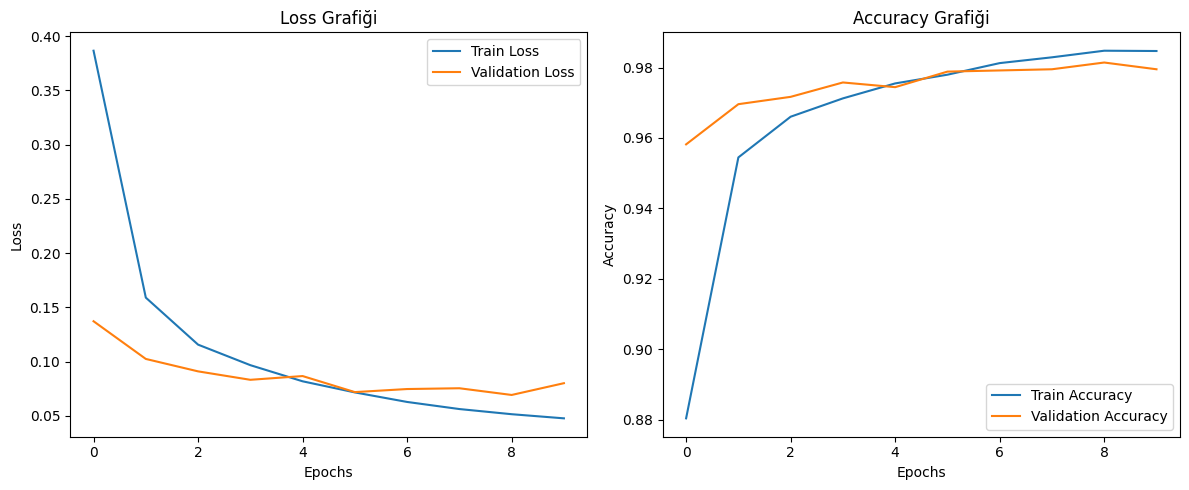

In [21]:
# Eğitim sonuçlarını görselleştirelim
plt.figure(figsize=(12, 5))

# Loss grafiği
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'], label='Train Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.title('Loss Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy grafiği
plt.subplot(1, 2, 2)
plt.plot(results.history['accuracy'], label='Train Accuracy')
plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
# Test seti ile tahmin yapalım
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [23]:
# Test seti üzerinde modeli değerlendirelim
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Test Loss: 0.07944244146347046
Test Accuracy: 0.9793999791145325
